In [29]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
import pandas as pd

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
sc = SparkContext()


In [3]:
sqlContext = SQLContext(sc)

In [4]:
#spark = org.apache.spark.sql.SparkSession.builder.master("local").appName("Spark CSV Reader").getOrCreate;
lines = sqlContext.read.format("csv").option("header","true").option("inferSchema","true").load('/Users/i303433/Desktop/project/FoodBalanceSheets_E_All_Data_(Normalized).csv')


In [15]:
lines.show()


+---------+-----------+---------+----------+------------+--------------------+---------+----+------------+-------+----+
|Area Code|       Area|Item_Code|      Item|Element_Code|             Element|Year_Code|Year|        Unit|  Value|Flag|
+---------+-----------+---------+----------+------------+--------------------+---------+----+------------+-------+----+
|        2|Afghanistan|     2501|Population|         511|Total Population ...|     1961|1961|1000 persons| 8954.0|null|
|        2|Afghanistan|     2501|Population|         511|Total Population ...|     1962|1962|1000 persons| 9142.0|null|
|        2|Afghanistan|     2501|Population|         511|Total Population ...|     1963|1963|1000 persons| 9340.0|null|
|        2|Afghanistan|     2501|Population|         511|Total Population ...|     1964|1964|1000 persons| 9547.0|null|
|        2|Afghanistan|     2501|Population|         511|Total Population ...|     1965|1965|1000 persons| 9765.0|null|
|        2|Afghanistan|     2501|Populat

In [5]:
lines.registerTempTable("production")

Query1: Top countries where growth of protein and fat supply over years is maximum as compared to others

In [138]:
fat_supply_intermediate = sqlContext.sql("SELECT Area, Year, sum(Value) as Total_Fat_per_year FROM production WHERE Element = 'Fat supply quantity (g/capita/day)' GROUP BY Area, Year")



In [139]:
protien_supply_intermediate = sqlContext.sql("SELECT Area, Year, sum(Value) as Total_Protien_per_year FROM production WHERE Element = 'Protein supply quantity (g/capita/day)' GROUP BY Area, Year")



In [140]:
fdsDF = fat_supply_intermediate.toPandas()


In [142]:
pdsDF = protien_supply_intermediate.toPandas()

In [145]:
CombineDF=pd.merge(pdsDF,fdsDF)

In [148]:
CombineDF["Total_Protien_per_year"] = pd.to_numeric(CombineDF["Total_Protien_per_year"])
CombineDF["Total_Fat_per_year"] = pd.to_numeric(CombineDF["Total_Fat_per_year"])

In [149]:
CombineDF["Percentage_change_Protien"]=CombineDF["Total_Protien_per_year"].pct_change()
CombineDF["Percentage_change_Fat"]=CombineDF["Total_Fat_per_year"].pct_change()


In [254]:
CombineDF = CombineDF.dropna()

In [255]:
schemaProtienFat = sqlContext.createDataFrame(CombineDF)

In [256]:
schemaProtienFat.registerTempTable("prodProteinFat")

In [257]:
protien_supply_top = sqlContext.sql("SELECT Area, sum(Percentage_change_Protien) as Total_Percentage_change_Protien FROM prodProteinFat GROUP BY Area order by sum(Percentage_change_Protien) desc LIMIT 5")

fat_supply_top = sqlContext.sql("SELECT Area, sum(Percentage_change_Fat) as Total_Percentage_change_Fat FROM prodProteinFat GROUP BY Area order by sum(Percentage_change_Fat) desc LIMIT 5")



In [258]:
protien_supply_top.show()

+---------+-------------------------------+
|     Area|Total_Percentage_change_Protien|
+---------+-------------------------------+
|Australia|             30.932105246712986|
|Argentina|              30.08079359718583|
|  Bermuda|             17.291750925741006|
|  Austria|             13.205451497538682|
|  Albania|             12.476862096972177|
+---------+-------------------------------+



In [259]:
fat_supply_top.show()

+------------------+---------------------------+
|              Area|Total_Percentage_change_Fat|
+------------------+---------------------------+
|           Austria|          61.00202230870306|
|         Australia|          57.81197049976316|
|Belgium-Luxembourg|          53.02950113178929|
|         Argentina|          52.60063129888069|
|           Bermuda|         46.819374969870076|
+------------------+---------------------------+



In [260]:
pdsPlot = protien_supply_top.toPandas()
fdsPlot = fat_supply_top.toPandas()

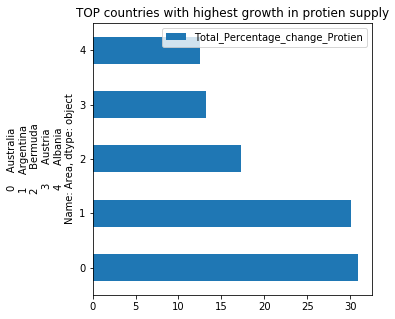

In [301]:

pdsPlot.plot(kind='barh', figsize=[5, 5])
plt.title('TOP countries with highest growth in protien supply')
plt.ylabel(pdsPlot['Area']);

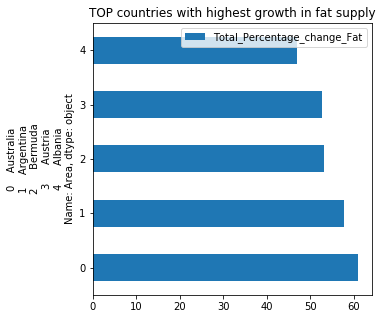

In [302]:
fdsPlot.plot(kind='barh', figsize=[5, 5])
plt.title('TOP countries with highest growth in fat supply')
plt.ylabel(pdsPlot['Area']);

In [263]:
u_cols = ['Developed', 'Developing', 'Underdeveloped']
countries = pd.read_csv('/Users/i303433/Desktop/project/Categories.csv', sep=',', names=u_cols,
                    encoding='latin-1')


In [222]:
countriesFrame = sqlContext.createDataFrame(countries)
countriesFrame.registerTempTable("Categories")

Query2: Diets in developing countries are changing as incomes rise. The share of staples, such as cereals is declining, while that of meat and dairy products is rising. 


In [187]:
cerealProd = sqlContext.sql("SELECT Area, Year, sum(Value) as Total_CerealProduction_per_year FROM production WHERE Item IN ('Cereals - Excluding Beer', 'Maize and products', 'Rice (Milled Equivalent)','Wheat and products') and Element = 'Food supply quantity (kg/capita/yr)' GROUP BY Area, Year")

meatDairyProd = sqlContext.sql("SELECT Area, Year, sum(Value) as Total_meat_Dairy_Production_per_year FROM production WHERE Item IN ('Meat', 'Butter, Ghee', 'Milk - Excluding Butter','Mutton & Goat Meat') and Element = 'Food supply quantity (kg/capita/yr)' GROUP BY Area, Year")


In [189]:
cerealPd=cerealProd.toPandas()
meatDairyPd = meatDairyProd.toPandas()
CombineCerealMeatDF=pd.merge(cerealPd,meatDairyPd)

In [190]:
CombineCerealMeatDF

,Area,Year,Total_CerealProduction_per_year,Total_meat_Dairy_Production_per_year
0,Angola,1979,150.67,101.96
1,Angola,1987,112.17,85.79
2,Antigua and Barbuda,1995,162.25,352.19
3,Argentina,2010,236.92,486.52
4,Azerbaijan,2012,470.61,333.05
5,Bahamas,1968,171.37,318.38
6,Bangladesh,1987,363.65,33.40
7,Botswana,1990,199.08,260.11
8,Afghanistan,1967,560.02,176.45
9,Argentina,1977,252.93,457.20


In [191]:
CombineCerealMeatDF["Total_CerealProduction_per_year"] = pd.to_numeric(CombineCerealMeatDF["Total_CerealProduction_per_year"])
CombineCerealMeatDF["Total_meat_Dairy_Production_per_year"] = pd.to_numeric(CombineCerealMeatDF["Total_meat_Dairy_Production_per_year"])

In [265]:
CombineCerealMeatDF["Percentage_change_Cereal"]=CombineCerealMeatDF["Total_CerealProduction_per_year"].pct_change()
CombineCerealMeatDF["Percentage_change_Meat_Dairy"]=CombineCerealMeatDF["Total_meat_Dairy_Production_per_year"].pct_change()
CombineCerealMeatDF = CombineCerealMeatDF.dropna()

In [266]:
schemaCereal_meat_dairy = sqlContext.createDataFrame(CombineCerealMeatDF)
schemaCereal_meat_dairy.registerTempTable("prodCerealMeatDairy")
cereal_supply_top = sqlContext.sql("SELECT Area, sum(Percentage_change_Cereal) as Total_Percentage_change_Cereal FROM prodCerealMeatDairy GROUP BY Area order by sum(Percentage_change_Cereal)")
dairy_meat_supply_top = sqlContext.sql("SELECT Area, sum(Percentage_change_Meat_Dairy) as Total_Percentage_change_Meat_Dairy FROM prodCerealMeatDairy GROUP BY Area order by sum(Percentage_change_Meat_Dairy)")




In [267]:
cerealPlot = cereal_supply_top.toPandas()
meatDairyPlot = dairy_meat_supply_top.toPandas()

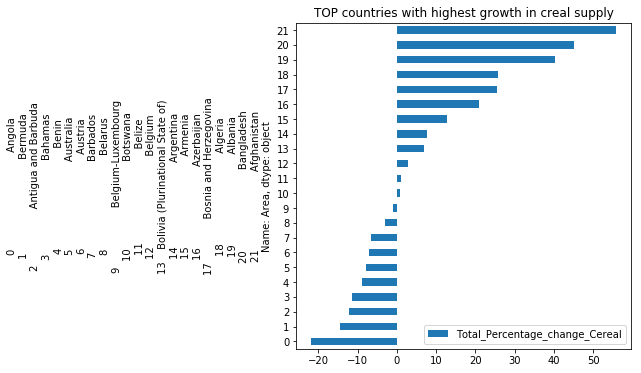

In [303]:
cerealPlot.plot(kind='barh', figsize=[6, 6])
plt.title('TOP countries with highest growth in creal supply')
plt.ylabel(cerealPlot['Area']);

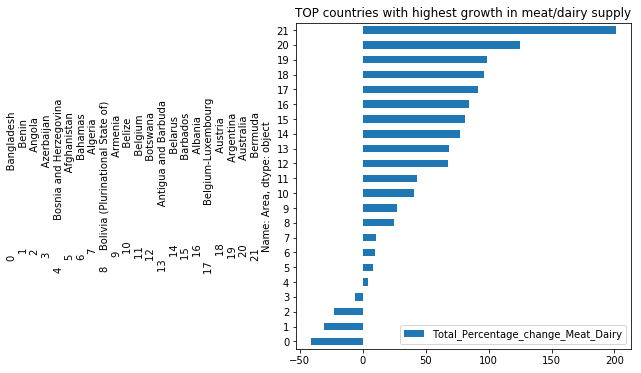

In [304]:
meatDairyPlot.plot(kind='barh', figsize=[6, 6])
plt.title('TOP countries with highest growth in meat/dairy supply')
plt.ylabel(meatDairyPlot['Area']);

In [270]:
cereal_supply_top.registerTempTable("CerealNumber")

dairy_meat_supply_top.registerTempTable("MeatDairyNumber")
cereal_supply_growth_increase = sqlContext.sql("SELECT count(1) FROM CerealNumber where Total_Percentage_change_Cereal > 0")
Meat_Dairy_supply_growth_increase = sqlContext.sql("SELECT count(1) FROM MeatDairyNumber where Total_Percentage_change_Meat_Dairy > 0")



In [271]:
cereal_supply_growth_increase.show()
#Number of countries which have growth in cereal and staple available for supply over years

+--------+
|count(1)|
+--------+
|      12|
+--------+



In [272]:
Meat_Dairy_supply_growth_increase.show()
#Number of countries which have growth in meat and dairy products available for supply over years

+--------+
|count(1)|
+--------+
|      18|
+--------+



In [273]:
TotalDF=pd.merge(cereal_supply_top.toPandas(),dairy_meat_supply_top.toPandas())
TotalDF['Difference'] = TotalDF['Total_Percentage_change_Meat_Dairy']-TotalDF['Total_Percentage_change_Cereal']

In [274]:
TotalDF

,Area,Total_Percentage_change_Cereal,Total_Percentage_change_Meat_Dairy,Difference
0,Angola,-21.788904,-23.024393,-1.235489
1,Bermuda,-14.482184,201.029843,215.512027
2,Antigua and Barbuda,-12.115020,68.541279,80.656300
3,Bahamas,-11.565551,9.565404,21.130955
4,Benin,-8.918407,-30.639734,-21.721327
5,Australia,-7.849061,125.232563,133.081623
6,Austria,-7.209407,96.444263,103.653671
7,Barbados,-6.515454,81.102605,87.618060
8,Belarus,-2.973635,77.361452,80.335087
9,Belgium-Luxembourg,-0.981214,91.301501,92.282715


In [275]:
schemaDifference = sqlContext.createDataFrame(TotalDF)
schemaDifference.registerTempTable("prodDifference")


In [276]:
#Number of countries which have growth in meat and dairy over cereal and staple available for supply over years in developed Countries cateogry
developedCountries = sqlContext.sql("SELECT count(1) FROM prodDifference where Difference > 0 AND Area IN (Select Developed from Categories)").show()
#Number of countries which have growth in meat and dairy over cereal and staple available for supply over years in developing Countries category
developingCountries = sqlContext.sql("SELECT count(1) FROM prodDifference where Difference > 0 AND Area IN (Select Developing from Categories)").show()
#Number of countries which have growth in meat and dairy over cereal and staple available for supply over years in under developed Countries category
UnderdevelopedCountries = sqlContext.sql("SELECT count(1) FROM prodDifference where Difference > 0 AND Area IN (Select Underdeveloped from Categories)").show()





+--------+
|count(1)|
+--------+
|       4|
+--------+

+--------+
|count(1)|
+--------+
|       3|
+--------+

+--------+
|count(1)|
+--------+
|       1|
+--------+



Query 3: How Calories available for consumption (food Security) changing across different continents

In [230]:
u_cols = ['Continent', 'Area']
continents = pd.read_csv('/Users/i303433/Desktop/project/Countries-Continents.csv', sep=',', names=u_cols,
                    encoding='latin-1')


In [245]:
food_supply_available = sqlContext.sql("SELECT Area, Year, sum(Value) as Total_Calorie_per_capita_per_day FROM production WHERE Element = 'Food supply (kcal/capita/day)' GROUP BY Area, Year")


In [246]:
foodDF=pd.merge(food_supply_available.toPandas(),continents)

In [247]:
foodDF

,Area,Year,Total_Calorie_per_capita_per_day,Continent
0,Angola,1979,7865.0,Africa
1,Angola,1987,6527.0,Africa
2,Angola,2010,9375.0,Africa
3,Angola,1977,7806.0,Africa
4,Angola,1984,6693.0,Africa
5,Angola,2012,9531.0,Africa
6,Angola,1964,7444.0,Africa
7,Angola,2003,7928.0,Africa
8,Angola,1983,6918.0,Africa
9,Angola,1989,6347.0,Africa


In [248]:
foodDF["Total_Calorie_per_capita_per_day"] = pd.to_numeric(foodDF["Total_Calorie_per_capita_per_day"])
foodDF["percentageChange_Calorie_per_capita_per_day"]=foodDF["Total_Calorie_per_capita_per_day"].pct_change()

In [277]:
foodDF = foodDF.dropna()

In [278]:
schemaCalorie = sqlContext.createDataFrame(foodDF)
schemaCalorie.registerTempTable("prodCalorie")


In [286]:
foodSecurity_top_africa = sqlContext.sql("SELECT Area, avg(percentageChange_Calorie_per_capita_per_day) as Average_Percentage_calorie FROM prodCalorie WHERE Continent = 'Africa' GROUP BY Area order by avg(percentageChange_Calorie_per_capita_per_day)").toPandas()
foodSecurity_top_europe = sqlContext.sql("SELECT Area, avg(percentageChange_Calorie_per_capita_per_day) as Average_Percentage_calorie FROM prodCalorie WHERE Continent = 'Europe' GROUP BY Area order by avg(percentageChange_Calorie_per_capita_per_day)").toPandas()
foodSecurity_top_asia = sqlContext.sql("SELECT Area, avg(percentageChange_Calorie_per_capita_per_day) as Average_Percentage_calorie FROM prodCalorie WHERE Continent = 'Asia' GROUP BY Area order by avg(percentageChange_Calorie_per_capita_per_day)").toPandas()
foodSecurity_top_north_America = sqlContext.sql("SELECT Area, avg(percentageChange_Calorie_per_capita_per_day) as Average_Percentage_calorie FROM prodCalorie WHERE Continent = 'North America' GROUP BY Area order by avg(percentageChange_Calorie_per_capita_per_day)").toPandas()
foodSecurity_top_south_America = sqlContext.sql("SELECT Area, avg(percentageChange_Calorie_per_capita_per_day) as Average_Percentage_calorie FROM prodCalorie WHERE Continent = 'Sorth America' GROUP BY Area order by avg(percentageChange_Calorie_per_capita_per_day)").toPandas()
foodSecurity_top_oceania = sqlContext.sql("SELECT Area, avg(percentageChange_Calorie_per_capita_per_day) as Average_Percentage_calorie FROM prodCalorie WHERE Continent = 'Oceania' GROUP BY Area order by avg(percentageChange_Calorie_per_capita_per_day)").toPandas()



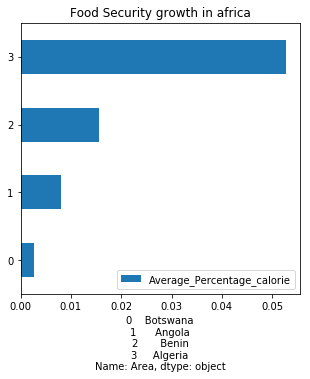

In [297]:
foodSecurity_top_africa.plot(kind='barh', figsize=[5, 5])
plt.title('Food Security growth in africa')
plt.xlabel(foodSecurity_top_africa['Area']);

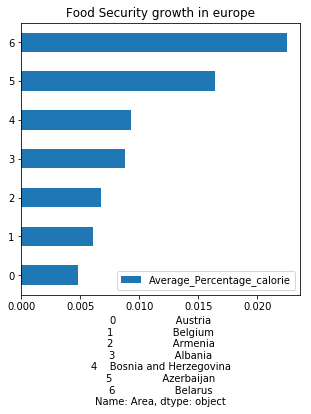

In [294]:
foodSecurity_top_europe.plot(kind='barh', figsize=[5, 5])
plt.title('Food Security growth in europe')
plt.xlabel(foodSecurity_top_europe['Area']);

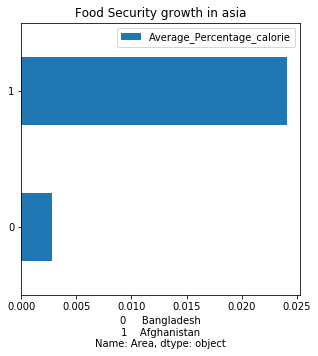

In [296]:
foodSecurity_top_asia.plot(kind='barh', figsize=[5, 5])
plt.title('Food Security growth in asia')
plt.xlabel(foodSecurity_top_asia['Area']);

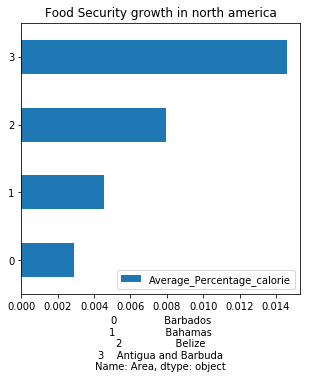

In [298]:
foodSecurity_top_north_America.plot(kind='barh', figsize=[5, 5])
plt.title('Food Security growth in north america')
plt.xlabel(foodSecurity_top_north_America['Area']);

In [299]:
foodSecurity_top_south_America.plot(kind='barh', figsize=[5, 5])
plt.title('Food Security growth in south america')
plt.xlabel(foodSecurity_top_south_America['Area']);

TypeError: Empty 'DataFrame': no numeric data to plot

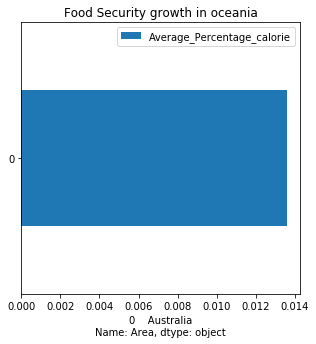

In [300]:
foodSecurity_top_oceania.plot(kind='barh', figsize=[5, 5])
plt.title('Food Security growth in oceania')
plt.xlabel(foodSecurity_top_oceania['Area']);

Query 4: Import

+-------+----+-------------------+
|   Area|Year|totalImportQuantity|
+-------+----+-------------------+
|Belgium|2012|            71032.0|
|Belgium|2013|            70551.0|
|Belgium|2011|            68272.0|
|Belgium|2010|            65385.0|
|Belgium|2008|            65322.0|
+-------+----+-------------------+
only showing top 5 rows



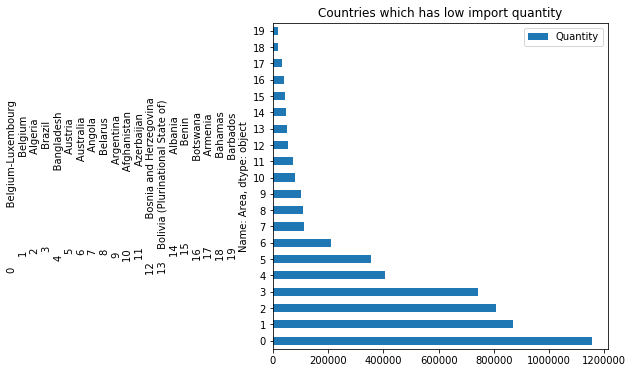

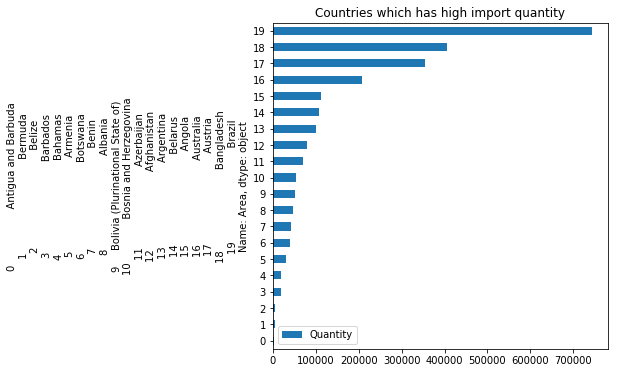

In [305]:
lines.registerTempTable("importDataset")

importQuantity = sqlContext.sql("SELECT Area, Year, sum(Value) as totalImportQuantity FROM importDataset WHERE Element = 'Import Quantity' and Area != 'World' GROUP BY Area, Year Order By totalImportQuantity desc")

importQuantity.show(5)

importQuantity = importQuantity.dropna()

importQuantity.registerTempTable("importQuantity_top_5")

import_top = sqlContext.sql("select Area,sum(totalImportQuantity) as Quantity from importQuantity_top_5 where GROUP BY Area order by sum(totalImportQuantity)  limit 20")

import_low = sqlContext.sql("select Area,sum(totalImportQuantity) as Quantity from importQuantity_top_5 where GROUP BY Area order by sum(totalImportQuantity) desc limit 20")

import_plot_high = import_top.toPandas()

import_plot_low = import_low.toPandas()

 

 

import_plot_low.plot(kind='barh', figsize=[6, 6])

plt.title('Countries which has low import quantity')

plt.ylabel(import_plot_low['Area']);

 

 

import_plot_high.plot(kind='barh', figsize=[6, 6])

plt.title('Countries which has high import quantity')

plt.ylabel(import_plot_high['Area']);

 

Query 5: Export

+------+----+-------------------+
|  Area|Year|totalexportQuantity|
+------+----+-------------------+
|Brazil|2013|           203012.0|
|Brazil|2012|           165916.0|
|Brazil|2011|           149411.0|
|Brazil|2010|           145481.0|
|Brazil|2009|           129842.0|
+------+----+-------------------+
only showing top 5 rows



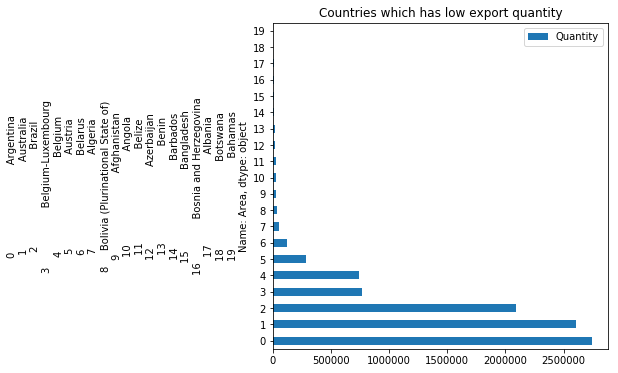

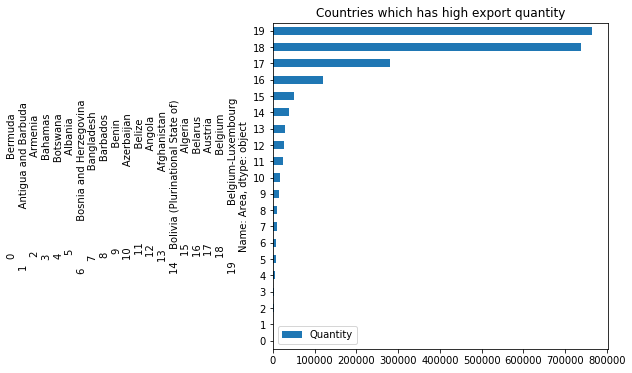

In [306]:
lines.registerTempTable("exportDataset")

exportQuantity = sqlContext.sql("SELECT Area, Year, sum(Value) as totalexportQuantity FROM exportDataset WHERE Element = 'Export Quantity' and Area != 'World' GROUP BY Area, Year Order By totalexportQuantity desc")

exportQuantity.show(5)

exportQuantity = exportQuantity.dropna()

exportQuantity.registerTempTable("exportQuantity_top_5")

export_top = sqlContext.sql("select Area,sum(totalexportQuantity) as Quantity from exportQuantity_top_5 where GROUP BY Area order by sum(totalexportQuantity)  limit 20")

export_low = sqlContext.sql("select Area,sum(totalexportQuantity) as Quantity from exportQuantity_top_5 where GROUP BY Area order by sum(totalexportQuantity) desc limit 20")

export_plot_high = export_top.toPandas()

export_plot_low = export_low.toPandas()

 

 

export_plot_low.plot(kind='barh', figsize=[6, 6])

plt.title('Countries which has low export quantity')

plt.ylabel(export_plot_low['Area']);

 

 

export_plot_high.plot(kind='barh', figsize=[6, 6])

plt.title('Countries which has high export quantity')

plt.ylabel(export_plot_high['Area']);

 

Query 6: Oilcrops

+------+----+--------------+
|  Area|Year|total_oilcrops|
+------+----+--------------+
|Brazil|1989|       68988.0|
|Brazil|1990|       65862.0|
|Brazil|1985|       58533.0|
|Brazil|1987|       58154.0|
|Brazil|1988|       57692.0|
+------+----+--------------+
only showing top 5 rows



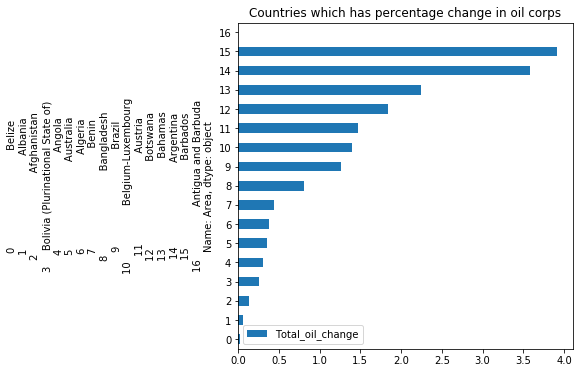

In [307]:
lines.registerTempTable("oilcropsDataSet")

oilCrops = sqlContext.sql("SELECT Area, Year, round(sum(Value)) as total_oilcrops FROM oilcropsDataSet WHERE Item = 'Oilcrops' and Area != 'World' and Year Between 1970 and 1990 GROUP BY Area, Year Order By total_oilcrops desc")

oilCrops.show(5)

oilCrops.registerTempTable("oilcorpstotal")

oilcoprs_top = sqlContext.sql("select Area,sum(total_oilcrops) as oilcorps from oilcorpstotal where GROUP BY Area order by sum(total_oilcrops)  limit 20")

oilcorps_plot_high = oilcoprs_top.toPandas()

 

oilcorps_plot_high['oilcorps'] = oilcorps_plot_high['oilcorps'].pct_change()

oilcorps_plot_high =oilcorps_plot_high.dropna()

 

oil = sqlContext.createDataFrame(oilcorps_plot_high)

oil.registerTempTable("oildata")

oiltop = sqlContext.sql("SELECT Area, sum(oilcorps) as Total_oil_change FROM oildata GROUP BY Area order by sum(oilcorps)")

oiltopplot = oiltop.toPandas()

 

oiltopplot.plot(kind='barh', figsize=[6, 6])

plt.title('Countries which has percentage change in oil corps')

plt.ylabel(oiltopplot['Area']);